In [1]:
from sigsen.simulator import SensorField
%matplotlib inline

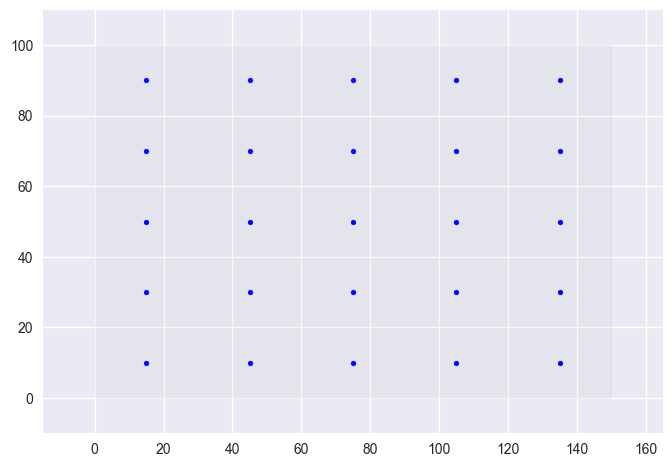

In [2]:
range = SensorField(0,150,0,100)
range.add_sensor_grid((5,5))
fig, ax = range.display()

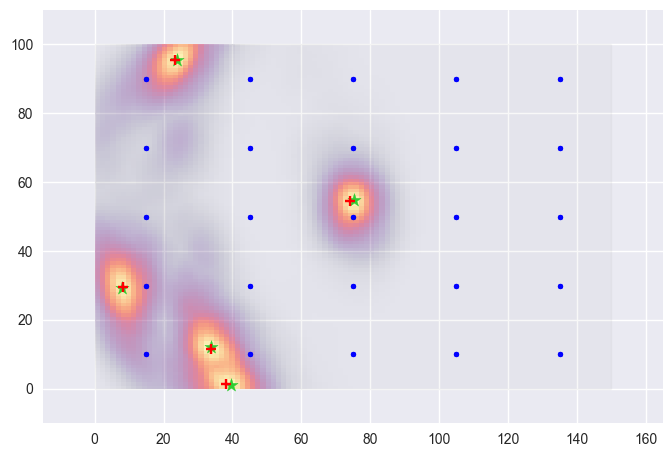

In [30]:
sigs = range.gen_data(5, noise=1)
sigs.compute_distribution((100,100))
_, _ = sigs.display(exp_factor=0.0025)